In [1]:
# run this twice
import os
import pandas as pd

In [2]:
os.chdir("/home/rocassius/w266_final/scripts/assembly")
from constant import DOC_SAMPLE_PATH
from subject import subject_keywords

In [3]:
os.chdir("/home/rocassius/w266_final/scripts/modeling")

In [4]:
from rmn import RMN

In [5]:
local_model_path = "/home/rocassius/gen-data/models"

In [20]:
from functools import partial
from multiprocessing import cpu_count, Pool

In [158]:
def parallel_list_map(lst, func, num_partitions=100, **kwargs):
    """
    Multi-threading helper to apply a function on a list. This function
    will return the same result as calling func(lst, **kwargs) directly.
    The function must take a list as input (may have other arguments) and
    return a list as its output.
    :param lst             The input list
    :param func            The function to be applied on the list
    :param num_partitions  Number of threads
    :return:               The same output list as returned by func(lst)
    """
    # Split the list based on number of partitions
    lst_split = [lst[i::num_partitions] for i in range(num_partitions)]
    # Create a thread pool
    pool = Pool(cpu_count())
    # Run the function and concatenate the result
    lst = np.concatenate(
        pool.map(partial(func, **kwargs), lst_split))
    # Clean up
    pool.close()
    pool.join()
    return lst

In [159]:
def prep_y(y, tokenizer_dict, embedding_matrix):
    """Returns the average of the vectors in each span of text
    """
    padded_spans = tokenizer_dict['tokenize_pad'](y)
    vector_spans = embedding_matrix[padded_spans].mean(axis=1)

    return vector_spans

def prep_metadata(metadata, metadata_dict):
    """
    data: a dictionary of metadata
    """

    metadata_ids = [np.array(metadata_dict[k]['tokenize'](metadata[k]))
                    for k in metadata_dict.keys()]

    return metadata_ids

In [174]:
#==================#
#=*= RMN Module =*=#
#==================#

# RMN Class for training Relationship Modeling Networks 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, Dense, Lambda, Input, Masking, Reshape
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.regularizers import Regularizer

from helper import pickle_object, load_pickled_object
from vector_math import find_nn_cos

# constants
MAX_SPAN_LENGTH = 50
NUM_TOPICS = 20
LAMBDA = 5.0

OPTIMIZER = 'adam'
BATCH_SIZE = 50
EPOCHS = 5

RMN_TAG = "rmn_%s"
MODEL = "model.h5"
ARCH = "architecture"
ATTR = "attributes"


class RMN(object):
    """
    Class for constructing a Relationship Modeling Network
    """
    
    def __init__(self):
        
        # model parameters
        self.num_topics = NUM_TOPICS
        self.lamb = LAMBDA
        
        # model attrbiutes
        self.embedding_matrix = None
        self.tokenizer_dict = None
        self.metadata_dict = None
        
        # models 
        self.model = None
        self.topic_model = None
        
    
    @property
    def embedding_dim(self):
        return self.embedding_matrix.shape[1]
    
    
    def model_loss(self):
        """Hinge loss function.
        """
        def custom_loss(y_true, y_pred):
            # hinge_loss
            y_true_normalized = K.l2_normalize(y_true, axis=-1)
            y_pred_normalized = K.l2_normalize(y_pred, axis=-1)
            dot_product = K.sum(y_true_normalized * y_pred_normalized, axis=-1)
            hinge_loss = K.mean(K.maximum(0., 1. - dot_product))

            return hinge_loss 

        return custom_loss
    
    
    def build_model(self):
        """Connstruct the RMN model architecture
        """
        # document span input
        vt = Input(shape=(self.embedding_dim, ), name='Span.Input')
    
        input_layers = [vt]
        embedding_layers = [vt]
        
        for col in self.metadata_dict.keys():
            
            input_layer = Input(shape=(1,), name= col + '.Input')
            
            # embedding layer for col
            embedding_init = Embedding(
                input_dim = self.metadata_dict[col]['input_dim'] + 1, 
                output_dim = self.embedding_dim,
                input_length = 1)(input_layer)
            
            # reshape
            embedding_layer = Reshape((self.embedding_dim, ), name=col + '.Embed.Layer')(embedding_init)
            
            input_layers.append(input_layer)
            embedding_layers.append(embedding_layer)

        # concat speaker metadata embeddings
        _ht = tf.keras.layers.Concatenate(axis=1, name = 'Concat.Layer')(embedding_layers)

        # dense layer
        ht = Dense(units = self.embedding_dim, 
                   input_shape = (_ht.shape[1], ), 
                   activation = "relu", name = "Wh")(_ht)

        # dense layer with softmax activation, (where previous states will eventually be inserted) 
        dt = Dense(units = self.num_topics, 
                   input_shape = (self.embedding_dim, ), 
                   activation = "softmax", name = "Wd")(ht)

        # reconstruction layer
        rt = Dense(units = self.embedding_dim,
                   input_shape = (self.num_topics, ),
                   activation = "linear",
                   kernel_regularizer = Orthogonality(self.lamb),
                   name = "R")(dt)

        # compile
        model = tf.keras.Model(inputs=input_layers, outputs=rt)
        model.compile(optimizer = OPTIMIZER, loss = self.model_loss())

        self.model = model
    
    
    def build_topic_model(self, topic_layer = "Wd"):
        """Contruct model whose output is the topic distribution layer
        """
        topic_model = tf.keras.Model(
            inputs = self.model.input,
            outputs = self.model.get_layer(topic_layer).output)
        
        self.topic_model = topic_model
    
    
    def prep_y(self, y):
        """Returns the average of the vectors in each span of text
        """
        return prep_y(y, self.tokenizer_dict, self.embedding_matrix)
    
    
    def prep_y_parallel(self, y):
        """
        Returns the average of the vectors in each span of text 
        via a parallel computation
        """
        return parallel_list_map(y, prep_y, 
                                 tokenizer_dict=self.tokenizer_dict, 
                                 embedding_matrix=self.embedding_matrix)
    
    
    def prep_metadata(self, metadata):
        """
        metadata: a dictionary of metadata
        """
        return prep_metadata(metadata, self.metadata_dict)
    
    
    def prep_metadata_parallel(self, metadata):
        """
        metadata: a dictionary of metadata
        """
        return parallel_list_map(metadata, prep_metadata, metadata_dict=self.metadata_dict)
        
    
    def prep_metadata_df(self, df):
        """Preps metadata for training or prediction
        """
        return self.prep_metadata(df.to_dict('series'))
    
    
    def prep_inputs(self, df):
        """Preps metadata for training or prediction
        """
        vector_spans = self.prep_y(df['document'])
        metadata_ids = self.prep_metadata(df)
        inputs = [vector_spans] + metadata_ids
        
        return inputs
    
    
    def predict_topics(self, df):
        """Predicts the topic distributions for a df
        """
        
        # ensure the topic model has been built
        if self.topic_model is None:
            self.build_topic_model()
            
        topic_preds = self.topic_model.predict(x=self.prep_inputs(df))
        
        return topic_preds
    
    
    def fit(self, df, batch_size = BATCH_SIZE, epochs = EPOCHS):
        
        inputs = self.prep_inputs(df)
        y_true = self.prep_y(df['document'])
        
        self.model.fit(x = inputs, 
                       y = y_true, 
                       batch_size = batch_size, 
                       epochs = epochs)

    
    def save_rmn(self, name, save_path):
        """
        Save the model's weights, architecture and attributes
        """
        
        # assemble attribute dictionary
        attribute_dict = {
            'num_topics': self.num_topics,
            'emedding_matrix': self.embedding_matrix,
            'tokenizer_dict': self.tokenizer_dict,
            'metadata_dict': self.metadata_dict}
        
        # make directory for model
        model_path = os.path.join(save_path, RMN_TAG % name)
        os.mkdir(model_path)
        
        # save model weights
        self.model.save(os.path.join(model_path, MODEL))
        
        # save model architecture
        pickle_object(self.model.to_json(), os.path.join(model_path, ARCH))
        
        # save model attributes
        pickle_object(attribute_dict, os.path.join(model_path, ATTR))
        
        
    def load_rmn(self, name, save_path):
        """
        Load the model, weights, architecture and attributes from a saved model
        """
        
        # make directory for model
        model_path = os.path.join(save_path, RMN_TAG % name)
        
        # Load architecture and weights
        self.model = model_from_json(load_pickled_object(os.path.join(model_path, ARCH)))
        self.model.load_weights(os.path.join(model_path, MODEL))
        
        # load attributes
        attributes_dict = load_pickled_object(os.path.join(model_path, ATTR))
        
        # update attributes
        self.num_topics = attributes_dict['num_topics']
        self.embedding_matrix = attributes_dict['emedding_matrix']
        self.tokenizer_dict = attributes_dict['tokenizer_dict']
        self.metadata_dict = attributes_dict['metadata_dict']
       
    
    def inspect_topics(self, k_neighbors=10):
        """
        Ouput the nearest neighbors of every topic vector in
        the model's topic layer
        """
    
        # get embedding matrix, dim = [num_words, embedding_dim]
        E = self.embedding_matrix
        
        # get topic matrix, dim = [num_topics, embedding_dim]
        Wd = self.model.get_layer('Wd').get_weights()[0].T
        
        for i in range(Wd.shape[0]):
            
            neighbors, sim = find_nn_cos(Wd[i], E, k_neighbors)
            words = [self.tokenizer_dict['tokenizer'].index_word[v] for v in neighbors]
            
            print(20*"=" +"\n")
            print("Topic", i)
            print(words)
            

In [175]:
rmn = RMN()
rmn.load_rmn(name = "second", save_path = local_model_path)

In [179]:
r = rmn.prep_metadata_parallel(df_sample)

In [182]:
r[0].shape

(10, 1)

In [172]:
m = rmn.prep_y_parallel(df_sample['document'])

In [173]:
m

array([[ 0.1494  , -0.0469  ,  0.1294  , ...,  0.02412 , -0.0662  ,
         0.1356  ],
       [ 0.1646  ,  0.104   ,  0.0941  , ...,  0.2107  ,  0.01041 ,
         0.4019  ],
       [-0.0449  ,  0.11426 , -0.03278 , ...,  0.1115  , -0.02898 ,
         0.317   ],
       ...,
       [ 0.1619  , -0.1621  , -0.01056 , ..., -0.06195 , -0.0337  ,
        -0.2183  ],
       [ 0.1709  , -0.2357  , -0.1113  , ...,  0.2866  ,  0.03757 ,
         0.12396 ],
       [ 0.1921  , -0.2142  ,  0.012505, ...,  0.0978  ,  0.0909  ,
        -0.151   ]], dtype=float16)

In [131]:
m.shape

(1000, 50)

In [123]:
np.concatenate([m[0], m[1][0:5]]).shape

(15, 50)

In [ ]:
np.array()

(10, 50)

In [7]:
subjects = [
    'alcohol',
 'budget',
 'business',
 'crime',
 'guns',
 'drugs',
 'defense',
 'economy',
 'education',
 'elections',
 'environment',
 'federalism',
 'foreign',
 'government',
 'health',
 'immigration',
 'justice',
 'labor',
 'mail',
 'minorities',
 'women',
 'money',
 'religion',
 'tax',
 'trade']

In [8]:
df_list = [pd.read_csv(os.path.join(DOC_SAMPLE_PATH, "documents_%s.txt" % s), sep = "|") for s in subjects]

In [9]:
df = pd.concat(df_list)

In [15]:
df.dtypes

speakerid    object
lastname     object
firstname    object
chamber      object
state        object
gender       object
party        object
document     object
congress     object
subject      object
dtype: object

In [13]:
df['congress'] = df['congress'].astype(str)
df['speakerid'] = df['speakerid'].astype(int).astype(str)

In [16]:
df_sample = df.sample(1000)

In [19]:
df.head()

,speakerid,lastname,firstname,chamber,state,gender,party,document,congress,subject
0,105111840,GINGRICH,NEWTON,H,GA,M,R,lyndon johnsons former advisor jimmy carters s...,105,alcohol
1,105110921,ASHCROFT,JOHN,S,MO,M,R,defective products placing burden responsible ...,105,alcohol
2,105114091,DODD,CHRISTOPHER,S,CT,M,D,supervision devastating longterm impact one st...,105,alcohol
3,105111431,MOYNIHAN,DANIEL,S,NY,M,D,protracted series negotiations ensued able upd...,105,alcohol
4,105116401,INOUYE,DANIEL,S,HI,M,D,days hospitalization emergency room visits vi...,105,alcohol


In [14]:
import time
start = time.time()

topic_preds = rmn.predict_topics(df)

end = time.time()
elapsed = end - start
print(round(elapsed / 60, 3), " minutes")

4.349  minutes


 original version took 4.349 minutes to prep data

In [21]:
topic_preds.shape

(1997661, 40)

In [ ]:
from scipy.spatial.distance import jensenshannon

In [26]:
df_105 = df[df['congress'] == '105']
df_guns = df_105[df_105['subject'] == 'guns']

In [27]:
df_guns_R = df_guns[df_guns['party'] == 'R']
df_guns_D = df_guns[df_guns['party'] == 'D']

In [28]:
df_guns_R.shape

(1944, 10)

In [29]:
for r in df_guns_R.itertuples():
    print(20*"=")
    print(r.document)

comments pleased noted unanimousconsent agreement sergeant arms floor discussed matter undertaking procedures set rotation staff members making sure senators informed remind senators probably
want commend district columbia eleanor leadership shown courage shown week week tom jim worked hearts last  years believe ways begun make progress easy done carefully cannot violate right citizens city let us candid first national capital unique obligation sides
never done past cost investigation basically set  estimated cost portion investigation dealt clearing misstatements received begun prepared gingrichs firm responsible member want members need judgment concerned precedent value believe everyone concerned understood
things encapsulated bill things sure ultimately detailed hearings going sound trying reform existing existing rigid many cases harms juvenile justice home states sure people aware mandates federal juvenile justice one called sight sound separation gotten way
modest loan guarantee

dollars wasted throughout world panic began imf imposed austerity measures driven indonesian currency record levels wonder riots begun break streets people killed currency worth  percent less year ago fact riots began take hold government raised cost fuel electricity
nuclear weapons delivery systems something goes heart security safety every american pointed corporations watchdogs government begun try put together prosecution involved breach security perhaps breaking action taken president undercut prosecution people concerned
enjoyment products made get us products like tobacco productsin fact vast majority productshave special protection produced manner harms someone individual country harmed use product recourse court system integral marketplace individual buys product ability go court
swiftly nation take great pride technology sector even greater pride robust sector economy continues thrive one frightening trend begun emerge congress consideration would directly involve federal gov


For subject $s$

* sample $n$ (R, D) pairs of documents, $n$ (R, R) pairs of documents, $n$ (D, D) pairs of documents,
* compute the mean JS divergence for the pairs in each groups, resulting in 3 mean JS divergences

In [98]:
import numpy as np
from scipy.spatial.distance import jensenshannon
np.random.seed(202)

In [164]:
from scipy.special import rel_entr

def jensenshannon(p, q, base=None):
    """
    Returns the JS divergence between two 1-dimensional probability vectors
    code taken from scipy and modified to fix bug
    
    """
    p = np.asarray(p)
    q = np.asarray(q)
    p = p / np.sum(p, axis=0)
    q = q / np.sum(q, axis=0)
    m = (p + q) / 2.0
    left = rel_entr(p, m)
    right = rel_entr(q, m)
    js = max(0, np.sum(left, axis=0) + np.sum(right, axis=0))
    if base is not None:
        js /= np.log(base)
    return np.sqrt(js / 2.0)

In [211]:
len(df_guns_R.sample(N)['speakerid'].unique())

180

In [229]:
np.random.choice([1,2], 2, c)

array([2, 1])

In [240]:
size = 1
sample_func = lambda df: df.sample(size)
stratifed_df = (df_guns
                .groupby('speakerid', as_index=False)
                .apply(sample_func)
                .sample(frac=1))
stratifed_df

,,speakerid,lastname,firstname,chamber,state,gender,party,document,congress,subject
161,2603,105113610,DOOLEY,CALVIN,H,CA,M,D,rise support colleagues support important bill...,105,guns
251,2324,105115190,SHAYS,CHRISTOPHER,H,CT,M,R,chestnuts wife wen ling five children janece j...,105,guns
451,2095,105121050,ROHRABACHER,DANA,H,CA,M,R,product deserve taxed technology given adversa...,105,guns
125,2353,105113120,LAFALCE,JOHN,H,NY,M,D,monthly previously unknown accounts activities...,105,guns
68,3423,105112330,CAMPBELL,TOM,H,CA,M,R,enabled support importance colleagues reservat...,105,guns
...,...,...,...,...,...,...,...,...,...,...,...
252,3410,105115211,THOMAS,CRAIG,S,WY,M,R,take advantage opportunity make changes think ...,105,guns
94,1311,105112651,NICKLES,DON,S,OK,M,R,grand jury testified senate chung made stateme...,105,guns
416,1392,105119920,JACKSON LEE,SHEILA,H,TX,F,D,disastrous crash equal value see could also le...,105,guns
432,3178,105120440,MCDERMOTT,JIM,H,WA,M,D,grand jury process congress world large allowe...,105,guns


In [277]:

def blocked_sample(df, col, size):
    """
    Returns a blocked random sample from df blocked on col.
    """
    return (df
            .groupby(col, as_index=False)
            .apply(lambda d: d.sample(size))
            .sample(frac=1))

In [314]:
def compute_diversity_scores(df):
    
    # sample
    #d = blocked_sample(df, col="party", size=1)
    d = df.sample(frac=1)
    
    # identify party members
    rep_df = d[d[PARTY] == REP]
    dem_df = d[d[PARTY] == DEM]
    
    div = {'inter_div': expected_div(rep_df, dem_df),
           'rep_div':   expected_div(rep_df),
           'dem_div':   expected_div(dem_df)}
    
    return div

In [315]:
REP = "R"
DEM = "D"
PARTY = "party"

In [316]:
def expected_div(df1, df2=None):

    if df2 is None: 
        df_A, df_B = df1[::2], df1[1::2]
    else:           
        df_A, df_B = df1, df2
    
    return mean_js_div(rmn.predict_topics(df_A), rmn.predict_topics(df_B))
    
    

In [317]:
def mean_js_div(p1, p2, base=2):
    """
    Compute mean JS divergence between two list of probability distributions
    """
    mean_js = np.mean([jensenshannon(p, q, base) for p,q in zip(p1, p2)])
    return round(mean_js, 3)
    

In [318]:
div = compute_diversity_scores(df_guns)
div

{'inter_div': 0.943, 'rep_div': 0.733, 'dem_div': 0.71}

In [292]:
compute_diversity_scores(df_guns)

{'inter_div': 0.921, 'rep_div': 0.0, 'dem_div': 0.0}

In [184]:
N = 500
guns_R1 = rmn.predict_topics(df_guns_R.sample(N))
guns_R2 = rmn.predict_topics(df_guns_R.sample(N))
guns_D1 = rmn.predict_topics(df_guns_D.sample(N))
guns_D2 = rmn.predict_topics(df_guns_D.sample(N))

In [186]:
np.mean(np.sum(guns_D2, axis =1))

1.0

In [187]:
np.sum(guns_R2 < 0)

0

In [188]:
mean_js_div(guns_R1, guns_D1)

0.8652300346301606

In [189]:
mean_js_div(guns_R2, guns_D2)

0.8638809636150603

In [190]:
mean_js_div(guns_R1, guns_R2)

0.8092438256342105

In [192]:
mean_js_div(guns_D1, guns_D2)

0.8175075847170676

In [194]:
v = [jensenshannon(p, q, base) for p, q in zip(guns_R1, guns_D1)]

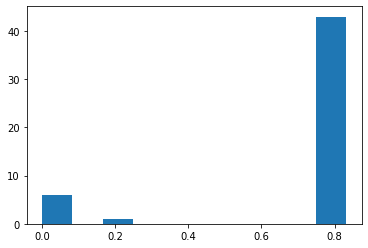

In [195]:
plt.hist(v)
plt.show()

In [183]:
np.mean(v)

0.8325546123015591

In [196]:
N = 500
guns_R1 = rmn.predict_topics(df_guns_R.sample(N))
guns_D1 = rmn.predict_topics(df_guns_D.sample(N))

guns_R = rmn.predict_topics(df_guns_R.sample(2 * N))
guns_D = rmn.predict_topics(df_guns_D.sample(2 * N))

In [198]:
mean_js_div(guns_R1, guns_D1)

0.9222369543227087

In [199]:
mean_js_div(guns_R[::2], guns_R[1::2])

0.7491371545942433

In [200]:
mean_js_div(guns_D[::2], guns_D[1::2])

0.7405008422872394

In [201]:
l = [1,2,3,4,5,6]

In [206]:
v = [jensenshannon(p, q, base) for p, q in zip(guns_D[::2], guns_D[1::2])]

(array([126.,   1.,   1.,   1.,   1.,   1.,   0.,   0.,   3., 366.]),
 array([0.        , 0.08325546, 0.16651092, 0.24976638, 0.33302184,
        0.41627731, 0.49953277, 0.58278823, 0.66604369, 0.74929915,
        0.83255461]),
 <a list of 10 Patch objects>)

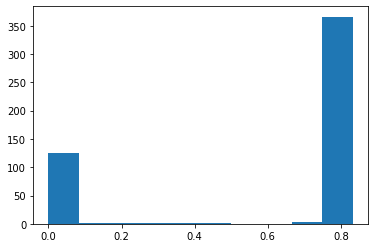

In [207]:
plt.hist(v)

(array([ 36.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,   0., 460.]),
 array([0.        , 0.08325546, 0.16651092, 0.24976638, 0.33302184,
        0.41627731, 0.49953277, 0.58278823, 0.66604369, 0.74929915,
        0.83255461]),
 <a list of 10 Patch objects>)

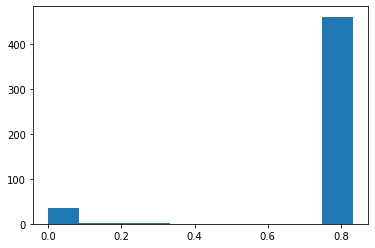

In [208]:
u = [jensenshannon(p, q, base) for p, q in zip(guns_R1, guns_D1)]

plt.hist(u)